# 1 Load libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
# import itertools
# import random # split datasets
# from sklearn.utils import resample
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# lightgbm
import lightgbm as lgb

# 2 Load datasets

In [2]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')

In [3]:
print(train.shape)
print(test.shape)

(590540, 289)
(506691, 289)


For avoiding LightGBM error: 
`LightGBMError: Do not support special JSON characters in feature name.`, rename the features

In [4]:
import re
train = train.rename(columns = lambda x:re.sub(':', '', x))
test = test.rename(columns = lambda x:re.sub(':', '', x))

Train / Validation Split

In [5]:
y = pd.DataFrame(train['isFraud'])
X = train.drop(columns=['isFraud'])
X_test = test.drop(columns=['isFraud'])

In [6]:
# index_array = np.arange(len(X))
# val_index = index_array[random.sample(range(0,X.shape[0]), X.shape[0]//5)]
# train_index = np.delete(index_array[:X.shape[0]], val_index, axis=0)
# len(train_index), len(val_index)

# X_train, X_val = X.iloc[train_index], X.iloc[val_index]
# y_train, y_val = y.iloc[train_index], y.iloc[val_index]

(472432, 118108)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# 3 Modeling
## 3.1 XGboost
### 3.1.1 Training

In [7]:
%%time

prediction_test_fold = []

param = {'booster' : 'gbtree',
         'max_depth' : 8, #14
         'nthread' : -1,
         'num_class' : 1,
         'objective' : 'binary:logistic',
         'silent' : 1,
         'eval_metric' : 'auc',
         'eta' : 0.01,
         'tree_method' : 'gpu_hist',
         'min_child_weight' : 0,
         'colsample_bytree' : 0.8,
         'colsample_bylevel' : 0.8,
         'seed' : 2019}



    
print("Train Shape :", X_train.shape,
      "Validation Shape :", X_val.shape,
      "Test Shape :", X_test.shape)
    
dtrn = xgb.DMatrix(X_train, label=y_train, feature_names = X.columns)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = X.columns)
dtst = xgb.DMatrix(X_test, feature_names = X.columns)
    
xgb1 = xgb.train(param, dtrn, num_boost_round=10000, evals = [(dtrn, 'train'), (dval, 'eval')],
                 early_stopping_rounds = 200, verbose_eval=200)
                 
prediction_XGB = xgb1.predict(dtst) # prediction of test
#prediction_test_fold.append(prediction_XGB)

prediction_val_XGB = xgb1.predict(xgb.DMatrix(X_val, feature_names = X.columns)) # prediction of validation

Train Shape : (413378, 288) Validation Shape : (177162, 288) Test Shape : (506691, 288)
[15:04:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.84291	eval-auc:0.84315
[200]	train-auc:0.88935	eval-auc:0.88785
[400]	train-auc:0.92295	eval-auc:0.91204
[600]	train-auc:0.94639	eval-auc:0.92947
[800]	train-auc:0.95575	eval-auc:0.93736
[1000]	train-auc:0.96098	eval-auc:0.94150
[1200]	train-auc:0.96501	eval-auc:0.94465
[1400]	train-auc:0.96856	eval-auc:0.94732
[1600]	train-auc:0.97102	eval-auc:0.94914
[1800]	train-auc:0.97369	eval-auc:0.95124
[2000]	train-auc:0.97557	eval-auc:0.95270
[2200]	train-auc:0.97766	eval-auc:0.95431
[2400]	train-auc:0.97960	eval-auc:0.95573
[2600]	train-auc:0.98125	eval-auc:0.95698
[2800]	train-auc:0.98280	eval-auc:0.95815
[3000]	train-auc:0.98424	eval-auc:0.95930
[3200]	train-auc:0.98543	eval-auc:0.96026
[3400]	tr

### 3.1.2 Confusion matrix

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
acc = accuracy_score(y_val, prediction_val_XGB.round())
auc = roc_auc_score(y_val, prediction_val_XGB.round())
rec = recall_score(y_val, prediction_val_XGB.round())
prec = precision_score(y_val, prediction_val_XGB.round())
f1 = f1_score(y_val, prediction_val_XGB.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))


accuracy = 0.9859
auc score = 0.8123
recall = 0.6254
precision = 0.9636
f1 score = 0.7585


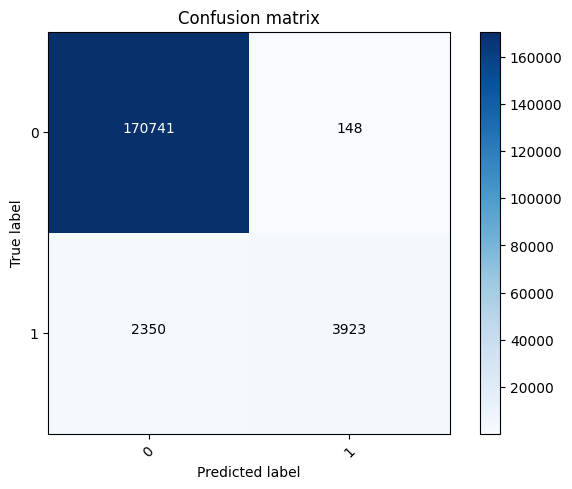

In [10]:
confusion_mtx = confusion_matrix(y_val, prediction_val_XGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

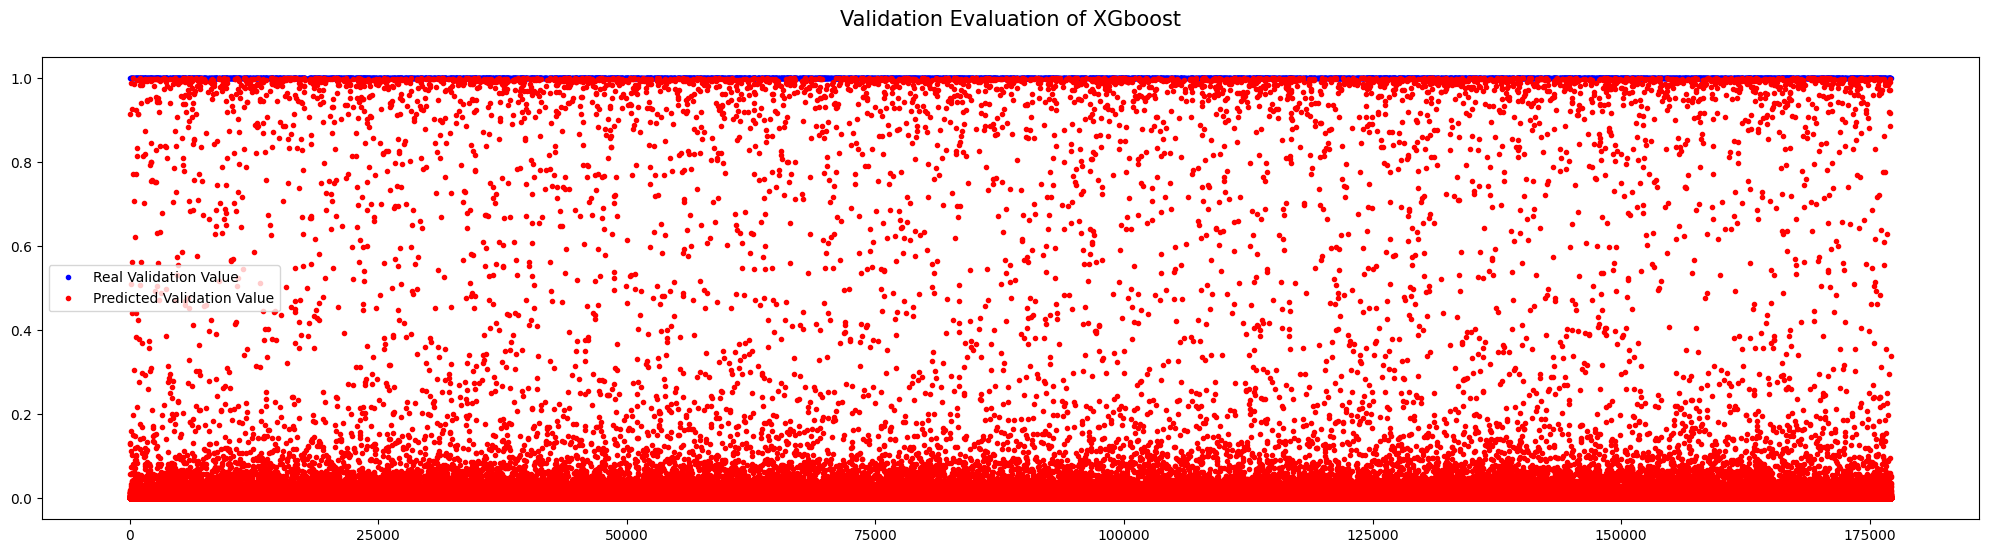

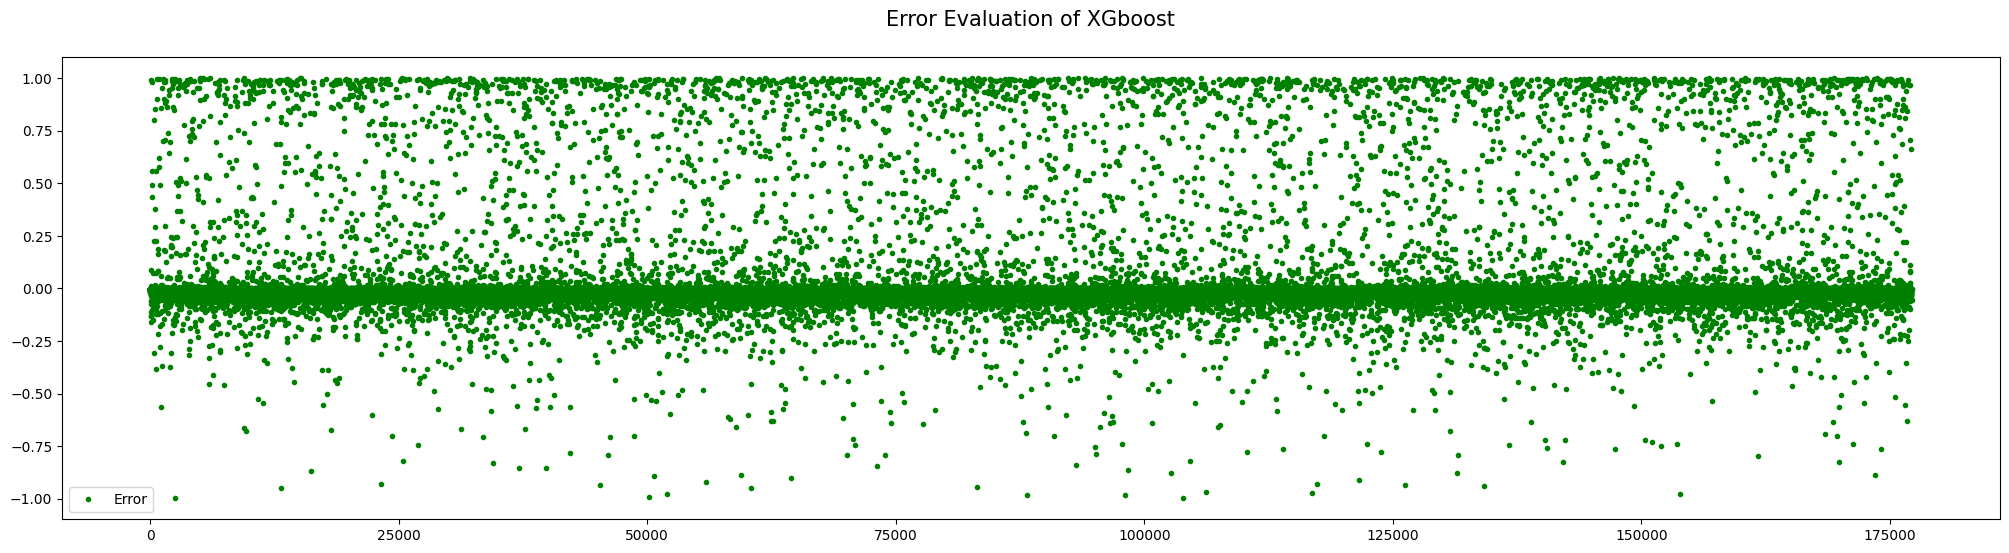

In [12]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_XGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_XGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

## 3.2 LightGBM
### 3.2.1 Training

In [13]:
%%time

params = {'num_leaves': 500,
          'min_child_weight': 0.03,
          'feature_fraction': 0.35,
          'bagging_fraction': 0.35,
          'min_data_in_leaf': 100,
          'objective': 'binary',
          'max_depth': 14,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 10,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.2,
          'reg_lambda': 0.6,
          'random_state': 50,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }


dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=200)
    

prediction_LGB = model.predict(X_test)
prediction_val_LGB = model.predict(X_val)

c:\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.93807	valid_1's auc: 0.920903
[200]	training's auc: 0.956046	valid_1's auc: 0.932863
[300]	training's auc: 0.969076	valid_1's auc: 0.941903
[400]	training's auc: 0.977648	valid_1's auc: 0.948804
[500]	training's auc: 0.982892	valid_1's auc: 0.953878
[600]	training's auc: 0.98636	valid_1's auc: 0.957571
[700]	training's auc: 0.988559	valid_1's auc: 0.959831
[800]	training's auc: 0.990148	valid_1's auc: 0.961641
[900]	training's auc: 0.9915	valid_1's auc: 0.963012
[1000]	training's auc: 0.992507	valid_1's auc: 0.964077
[1100]	training's auc: 0.993205	valid_1's auc: 0.964839
[1200]	training's auc: 0.993783	valid_1's auc: 0.965469
[1300]	training's auc: 0.994397	valid_1's auc: 0.966121
[1400]	training's auc: 0.994919	valid_1's auc: 0.96675
[1500]	training's auc: 0.995406	valid_1's auc: 0.967365
[1600]	training's auc: 0.995791	valid_1's auc: 0.967826
[1700]	training's auc: 0.996125	valid_1's auc: 0.968209


### 3.2.2 Confusion matrix

In [22]:
# metrics.accuracy_score(y_val, prediction_val_LGB.round())*100

acc = accuracy_score(y_val, prediction_val_LGB.round())
auc = roc_auc_score(y_val, prediction_val_LGB.round())
rec = recall_score(y_val, prediction_val_LGB.round())
prec = precision_score(y_val, prediction_val_LGB.round())
f1 = f1_score(y_val, prediction_val_LGB.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.9862
auc score = 0.8151
recall = 0.631
precision = 0.9701
f1 score = 0.7646


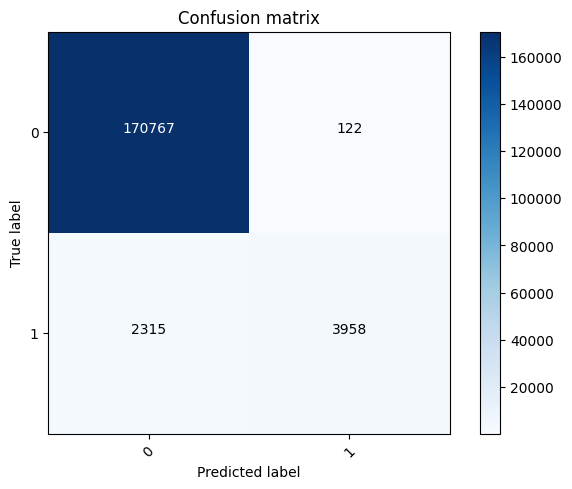

In [17]:
confusion_mtx = confusion_matrix(y_val, prediction_val_LGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

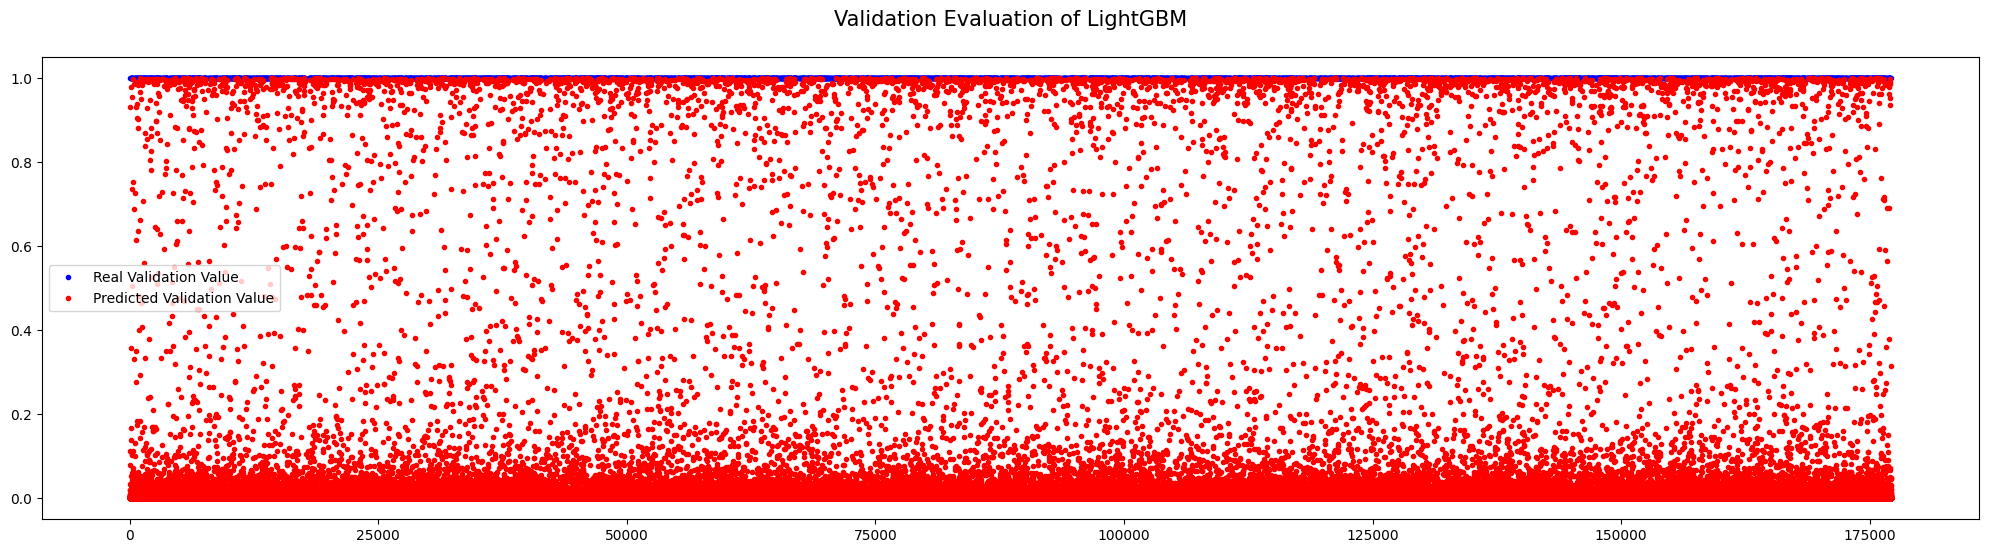

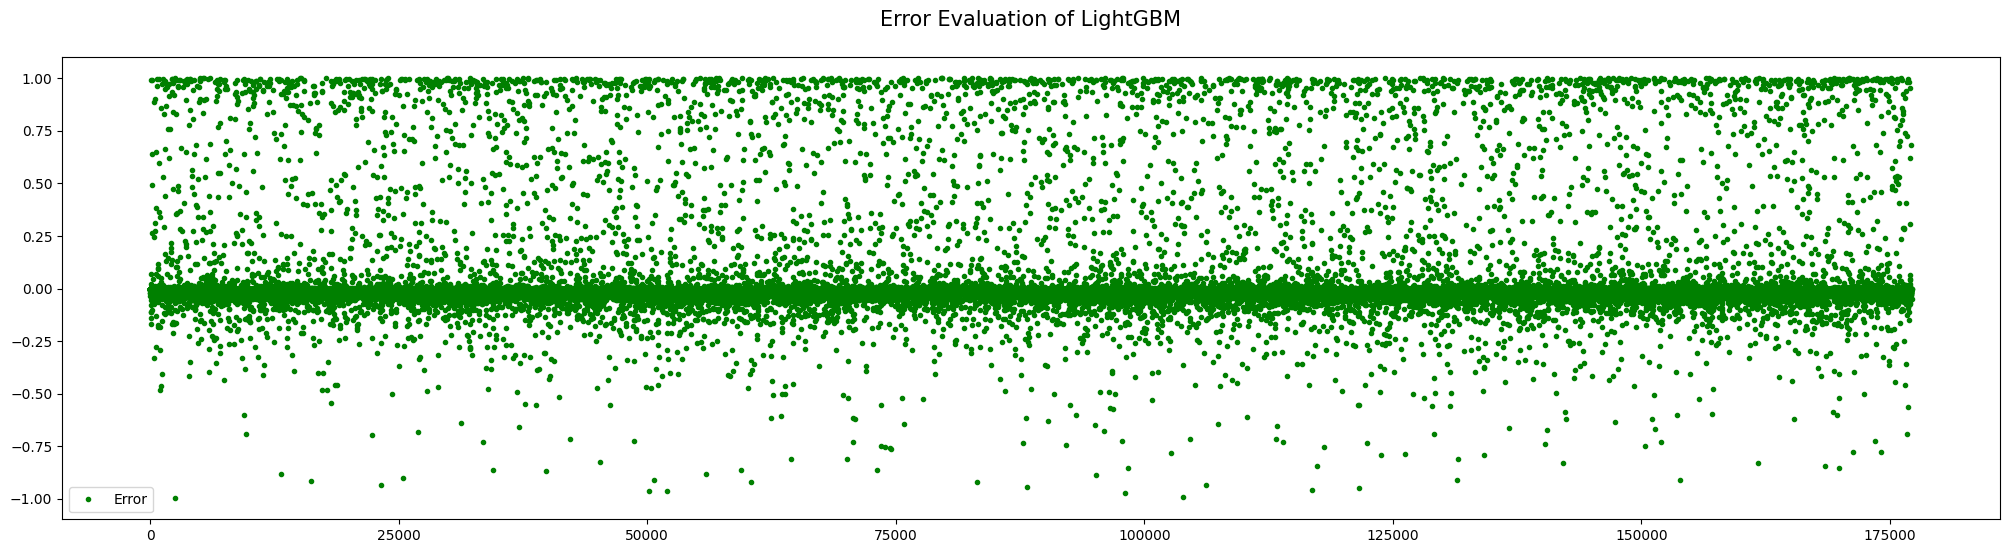

In [18]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_LGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_LGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

# 4 Submission

In [17]:
sample_submission = pd.read_csv('input/sample_submission.csv', index_col='TransactionID')

In [18]:
sample_submission.shape

(506691, 1)

In [19]:
sample_submission['isFraud'] = np.nan
sample_submission.head()

,isFraud
TransactionID,
3663549,NaN
3663550,NaN
3663551,NaN
3663552,NaN
3663553,NaN


In [20]:
xgb_sub, lgb_sub = sample_submission, sample_submission

## 4.1 XGboost

In [21]:
xgb_sub['isFraud'] = (0.5 * prediction_XGB) + (0.5 * prediction_XGB)
xgb_sub.head()

,isFraud
TransactionID,
3663549,0.000621
3663550,0.000112
3663551,0.000144
3663552,0.000098
3663553,0.000148


In [22]:
xgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.734225
3663780,0.108966
3663811,0.121282
3663827,0.389538
3663828,0.179083
...,...
4170032,0.260585
4170059,0.344869
4170078,0.656466


In [23]:
xgb_sub.to_csv('submission/sample_xgboost.csv')

## 4.2 LightGBM

In [24]:
lgb_sub['isFraud'] = (0.5 * prediction_LGB) + (0.5 * prediction_LGB)
lgb_sub.head()

,isFraud
TransactionID,
3663549,0.000138
3663550,0.000020
3663551,0.000093
3663552,0.000050
3663553,0.000006


In [25]:
lgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.932748
3663821,0.100388
3663827,0.810895
3663828,0.462807
3663836,0.900340
...,...
4170021,0.999581
4170059,0.470272
4170069,0.101570


In [26]:
lgb_sub.to_csv('submission/sample_lightgbm.csv')